# 2022-01-14 Function errors

* Summing series
* Conditioning
* Relative and absolute errors
* Activity

In [ ]:
using Plots
default(linewidth=4)

# What is floating point arithmetic?

1. fuzzy arithmetic
2. exact arithmetic, correctly rounded
3. the primary focus of numerical analysis

In [1]:
0.1 + 0.2

0.30000000000000004

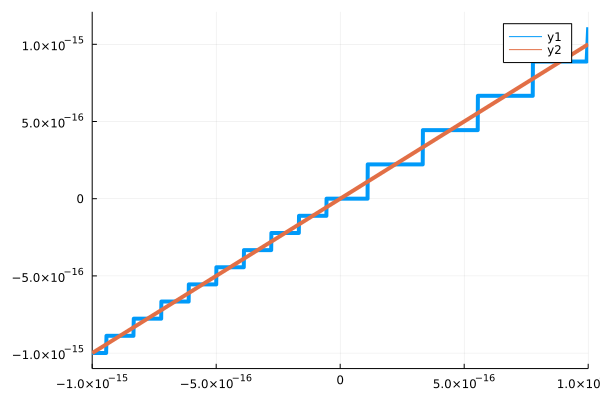

In [3]:
plot(x -> (1 + x) - 1, xlims=(-1e-15, 1e-15))
plot!(x -> x)

# Machine epsilon

We approximate real numbers with **floating point** arithmetic, which can only represent discrete values. In particular, there exists a largest number, which we call $\epsilon_{\text{machine}}$, such that
$$ 1 \oplus x = 1 \quad \text{for all}\  \lvert x \rvert < \epsilon_{\text{machine}}.$$

The notation $\oplus, \ominus, \odot, \oslash$ represent the elementary operation carried out in floating point arithmetic.

In [80]:
eps = 1
while 1 + eps != 1
    eps = eps / 2
end
eps

1.1102230246251565e-16

In [81]:
eps = 1.f0
while 1 + eps != 1
    eps = eps / 2
end
eps

5.9604645f-8

# Beating `exp`

$$e^x = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \dotsb$$

Suppose we want to compute $f(x) = e^x - 1$ for small values of $x$.

In [89]:
f1(x) = exp(x) - 1
y1 = f1(1e-8)

9.99999993922529e-9

In [87]:
f2(x) = x + x^2/2 + x^3/6
y2 = f2(1e-8)

1.000000005e-8

Which answer is more accurate?

In [27]:
@show (y1 - y2)        # Absolute difference
@show (y1 - y2) / y2;  # Relative difference

y1 - y2 = -1.1077470910720506e-16
(y1 - y2) / y2 = -1.1077470855333152e-8


# Conditioning

We say that a mathematical function $f(x)$ is well conditioned if small changes in $x$ produce small changes in $f(x)$.
(What we mean by "small" will be made more precise.)

The function $f(x)$ may represent a simple expression such as

* $f(x) := 2 x$
* $f(x) := \sqrt{x}$
* $f(x) := \log{x}$
* $f(x) := x - 1$


# Conditioning

A function may also represent something more complicated, implementable on a computer or by physical experiment.

* Find the positive root of the polynomial $t^2 + (1-x)t - x.$
* Find the eigenvectors of the matrix
$$ A(x) = \begin{bmatrix} 1 & 1 \\ 0 & x \end{bmatrix} .$$
* Find much the bridge flexes when the truck of mass $x$ drives over it.
* Find how long it takes to clean up when the toddler knocks the glass off the counter, as a function of the chair location $x$.
* Find the length of the rubber band when it finally snaps, as a function of temperature $x$ during manufacturing.
* Find the time at which the slope avalanches as a function of the wind speed $x$ during the storm.
* Find the probability that the slope avalanches in the next 48 hours as a function of the wind speed $x$ during the storm.
* Find the probability that the hurricane makes landfall as a function of the observations $x$.


# Specification

* Some of these problems are fully-specified
* Others involve sophisticated models and ongoing community research problems.
* In some cases, the models that are computable may incur greater uncertainty than the underlying system. In such cases, an analog experiment might produce smoother variation of the output as the problem data $x$ are varied.
* In others, the model might be better behaved than what it seeks to model.
* Some of these problems may be **ill-posed**

## Well-posedness

A problem is said to be [well-posed](https://en.wikipedia.org/wiki/Well-posed_problem) if
1. a solution exists,
2. the solution is unique, and
3. the solution depends continuously on the problem specification.

Mathematically, continuous variation in part 3 can be arbitrarily fast, but there may be measurement error, manufacturing tolerances, or incomplete specification in real-world problems, such that we need to quantify part 3.  This is the role of **conditioning**.


# Computing $e^x$

$$ e^x = \sum_{k=0}^{\infty} x^k/k! $$

In [4]:
function myexp(x)
    sum = 1
    for k in 1:100
        sum += x^k / factorial(k)
    end
    return sum
end
myexp(1) - exp(1)

LoadError: OverflowError: 21 is too large to look up in the table; consider using `factorial(big(21))` instead

In [7]:
function myexp(x)
    sum = 0
    term = 1
    n = 1
    while sum + term != sum
        sum += term
        term *= x / n
        n += 1
    end
    sum
end
myexp(1) - exp(1)

4.440892098500626e-16

# How accurate is it?

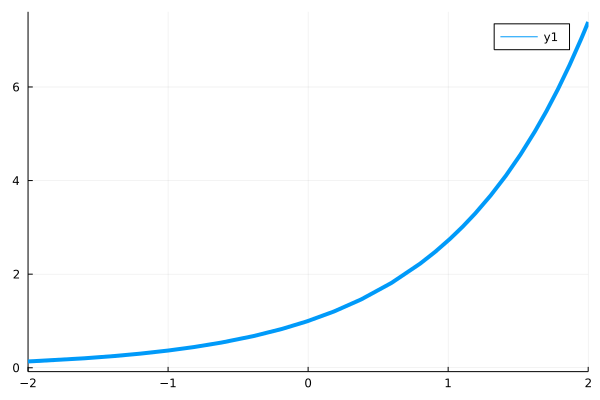

In [8]:
plot(myexp, xlims=(-2, 2))

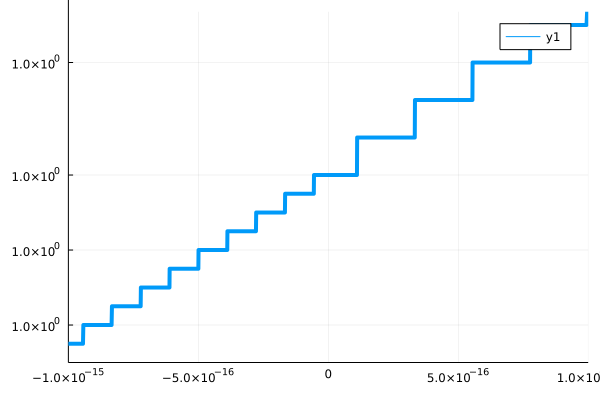

GKS: Possible loss of precision in routine SET_WINDOW


In [9]:
plot(myexp, xlims=(-1e-15, 1e-15))

# What's happening?

* We're computing $f(x) = e^x$ for values of $x$ near zero.
* This function is well approximated by $1 + x$.
* Values of $y$ near 1 cannot represent every value.
* After rounding, the error in our computed output $\tilde f(x)$ is of order $\epsilon_{\text{machine}}$.

## Absolute Error
$$ \lvert \tilde f(x) - f(x) \rvert $$

## Relative Error
$$ \lvert \tilde f(x) - f(x) \rvert / \lvert f(x) \rvert $$

# Suppose I want to compute $e^x - 1$

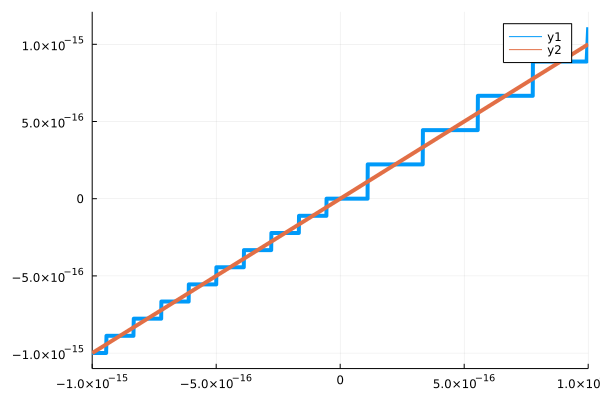

In [10]:
plot([x -> myexp(x) - 1 , x -> x],
     xlims=(-1e-15, 1e-15))

## What now?

* We're capable of representing outputs with 16 digits of accuracy
* Yet our algorithm `myexp(x) - 1` can't find them
* We can't recover without modifying our code

# Modify the code

In [14]:
function myexpm1(x)
    sum = 0
    term = x
    n = 2
    while sum + term != sum
        sum += term
        term *= x / n
        n += 1
    end
    sum
end

myexpm1 (generic function with 1 method)

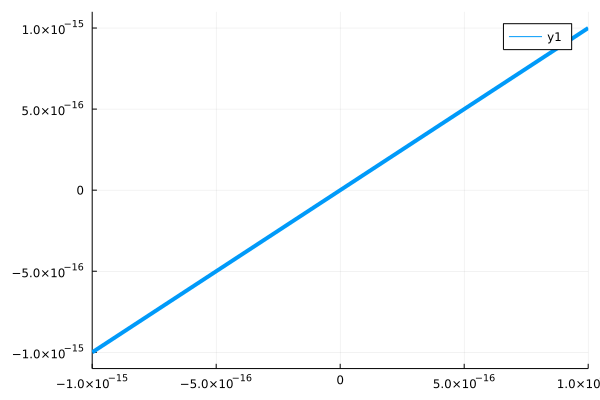

In [15]:
plot(myexpm1, xlims=(-1e-15, 1e-15))

# Plot relative error

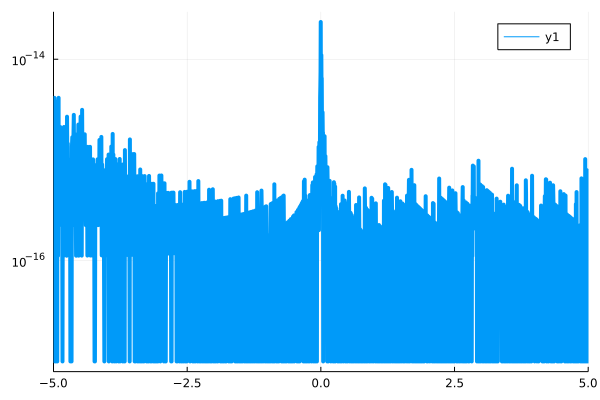

In [29]:
function relerror(x, f, f_ref)
    fx = f(x)
    fx_ref = f_ref(x)
    max(abs(fx - fx_ref) / abs(fx), 1e-17)
end
badexpm1(t) = exp(t) - 1
plot(x -> relerror(x, badexpm1, myexpm1), yscale=:log10, xrange=(-5, 5))

# Activity: [2022-01-12-taylor-series](https://classroom.github.com/a/VkPvGOgu)

* Use Julia, Jupyter, Git
* Look at how fast series converge when taking only finitely many terms
* Explore instability, as is occuring for large negative `x` above, but not for the standard library `expm1`